# HW4: Do we really need Chocolate Recommendations?

<img src="http://1.bp.blogspot.com/-8dGYKeMKNaU/TvutmCenc-I/AAAAAAAABEo/b2Czf4RlAzw/s1600/Death%2BBy%2BChocolate.JPG" width="400" height="300"/>

### Before You Start

This is a **long** homework. Please start early. It uses a lot of different (and sometimes complex) concepts, so you might find yourself reading a lot. So, please, give yourself a lot of time.

Also, please see this [link](http://nbviewer.ipython.org/urls/raw.github.com/cs109/content/master/InstructionsForAmazonEMR.ipynb) on getting an Amazon Web Services account soon, so that you don't delay its creation. This class gives you $100 in credits which you will use for this homework, possibly your project, and any other projects you might like.


In [5]:
%%bash
mkdir -p data

### Collaborative Filtering systems

In this homework, you will create a recommendation system for **restaurants** using [collaborative filtering](http://en.wikipedia.org/wiki/Collaborative_filtering) (CF). The general structure of a recommendation system is that there are users and there are items. Users express explicit or implicit preferences towards certain items. CF thus relies on users' past behavior.

There are two primary approaches to CF: neighboorhood and latent factor model. The former is concerned with computing the relationships between items or between users. In the latter approach you have a model of hidden factors through which users and items are transformed to the same space. For example, if you are rating movies we may transform items into genre factors, and users into their preference for a particular genre.

Factor models generally lead to more accurate recommenders. One of the reasons for this is the sparsity of the item-user matrix. Most users tend to rate barely one or two items. Latent factor models are more expressive, and fit fewer parameters. However, neighborhood models are more prevalent, as they have an intuitive aspect that appeals to users(if you liked this you will like that) and online(a new preference can be incorporated very quickly).

Most recommenders today combine neighboorhood CF with model based CF, and SVD based matrix factorization approaches.

To see the example of a simple beer recommender, go [here](http://nbviewer.ipython.org/20a18d52c539b87de2af). This homework is inspired by the one there but we go after food instead, and go deeper into the problem of making recommendations.

### User and Item based approaches

Original approaches to neighborhood based CF used user-user models. By this we mean that rating estimates are made from recorded ratings of like minded users. However, since most users tend to rate very few items, this is usually a losing proposition for explicit-rating based recommenders. Thus, most neighborhood based systems such as Amazon these days rely on item-item approaches. In these methods, a rating is estimated by other ratings made by the user on "similar" or "nearby" items: we have a K-Nearest-Neighbors algorithm, in effect.

### Outline of this Homework

The outline of this homework is as follows:

1. Create a database of item-item similarities. Use this to implement a neighborhood-based CF recommender that can answer simple questions like "give me more restaurants like this one". This part of the homework assumes that the similaties calculated make good "global recommendations".

2. In the second part, we go one step further and attempt to predict the rating that a user will give an item they have not seen before. This requires that we find the restaurants that *this* user would rate as similar (not just those which are globally similar). 

3. In the third part, we implement a factor-based CF recommender using a Bayesian model. While quite a bit more complex, this allows us to pool information both about similar users and about similar restaurants.

5. We will scale up our system by creating a recommender on the lines of Q1 and Q2 that works on the entire data set. We will use the map-reduce paradigm to split the computation over multiple machines.

You will start simply, by working on a subset of the restaurant data before generalizing to the entire data set in Problem 4. The complete data set has 150,000 reviews, but we shall start with just about 7000. You will create this  smaller set by taking all the users who had rated more than 60 restaurants, and all the businesses which had greater than 150 reviews from the larger data set. This is not a random set: indeed we use it as it a computationally tractable set that is a bit less sparse than the entire data set.

In [10]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

/home/stuff/anaconda3/envs/DataScience-Project/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Description of the data set

The data set has been extracted from the Yelp Phoenix restaurants dataset. It is available [here](https://dl.dropboxusercontent.com/u/75194/bigdf.csv).

In [8]:
%%bash
if [ ! -f data/bigdf.csv ]; then
    curl https://dl.dropboxusercontent.com/u/75194/bigdf.csv -o data/bigdf.csv
fi

In [11]:
fulldf=pd.read_csv("data/bigdf.csv")
fulldf.head(2)

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57


The data frame is a frame of reviews. We have joined in information about users and businesses into this frame so that you have only one frame to work with.

This information is for the reviews themselves:

Here is a description of the data fields in this dataframe, on the business side

And Finally, a set of fields for users

In this data set, every user has only one review for each restaurant. Convince yourself of this. (This answer does not need to be submitted).

In [17]:
#This should be empty
[g[0] for g in fulldf.groupby("user_id").groups.items() if len(fulldf.loc[g[1]]) > len(fulldf.loc[g[1]].business_id.unique())]

[]

> Convinced

### Our Recommender

To motivate our recommendation system, consider the follwing example. Let's pretend we are in Boston for a second. Lets say the average rating of restaurants here by all the users is 3.5. Sandrine's at Harvard square is better than an average restaurant, so it tends to be rated 0.5 stars above the average (over all the users). However, you are a curmudgeon, who tends to rate 0.2 stars below the average. Then a baseline estimate for the recommendation for Sandrine's, for you, is 3.5+0.5-0.2=3.8.

These baseline estimates thus adjust the data by accounting for the systematic tendencies for some users who give higher ratings than others, and for some restaurants to recieve higher ratings than others. We can write the baseline estimate $\hat Y_{um}^{baseline}$ for an unknown rating $Y_{um}$ for user $u$ and restaurant or business $m$ as:

$$ \hat Y_{um}^{baseline} = \hat \mu + \hat \theta_{u0} + \hat \gamma_{m0} $$

where the unknown parameters $\theta_{u0}$ and $\gamma_{m0}$ indicate the deviations, or biases, of user $u$ and item $m$, respectively, from some intercept parameter $\mu$. (The reason for the strange notation with 0s will become clear in Problem 3)

Notice that the $\theta_{u0}$ and $\gamma_{m0}$ are parameters which need to be fit. The simplest thing to start with, and something we will do for Problems 1 and 2 (but not 3), is to replace them by their "mean" estimates from the data. Thus:

$$ \hat Y^{baseline}_{um} = \bar Y + (\bar Y_u - \bar Y) + (\bar Y_m - \bar Y)$$

where $\bar Y_u$ =  `user_avg`, the average of all a user $u$'s ratings and $\bar Y_m$ = `business_avg`, the average of all ratings for a restaurant $m$. $\bar Y$ is the average rating over all reviews.

The final two terms correspond to the user-specific and item-specific bias in ratings, that is, how their ratings tend to systematically diverge from the global average. This is the simplest possible way to predict a rating, based only on information about *this* user and *this* restaurant.

Can we do a better job of predicting the rating $Y_{um}$ user $u$ would give to restaurant $r$? According to the central dogma of CF, we ought to be able to use the responses of *similar* users regarding *similar* restaurants to get a better prediction. 

We can make an estimate of $Y_{um}$ as:

$$ \hat{Y_{um}} = \hat Y_{um}^{baseline}\, + \,\frac{\sum\limits_{j \in S^{k}(m)} s_{mj} ( Y_{uj} - \hat Y_{uj}^{baseline} )}{\sum\limits_{j \in S^{k}(m)} s_{mj} } $$

where $s^{k}(m)$ is the $k$ neighbor items of item $m$ based on some pooling criterion, for example, those items which have been rated by user $u$.

In the next two problems, we will focus on using similar restaurants, or the item neighborhood.
To do this, we compute a *similarity measure* $s_{mj}$ between the $m$th and $j$th items. This similarity might be measured via [cosine similarity](http://en.wikipedia.org/wiki/Cosine_similarity), [pearson co-efficient](http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) or using other distance based measures. Here we shall use the Pearson coefficient. This measures the tendency of users to rate items similarly. Since most ratings are unknown, it is computed on the "common user support" (`n_common`), which is the set of common raters of both items. 

In the first problem we shall set $S$ to the global neighborhood of the item, and in the second we shall set it to those items which have been rated by user $u$.

## Q1. Writing a simple "global" recommender

Now we have a way to pool information between similar restaurants to try to predict a user's recommendation. But how do we choose the neighborhood to pool over? We begin with the simplest choice. We calculate the similarity between items using their entire common user support, and rank the nearest neighbors of an item by this similarity. We call this a "global" recommender because it assumes that every user perceives the similarity between restaurants in the same way. Later on, we will implement a more specific recommender that pools information based on which items seem the most similar *to this user*.

The global recommender does have the advantage of dealing with the possible sparsity of the user's rated items, but also the disadvantage of giving one answer for all users, without taking the user's preferences into account. This is a classic case of bias-variance tradeoff.

Lets implement this simpler global recommender first.


### Exploratory Data Analysis

**1.1** Visualize the sparsity of the full data set by plotting two histograms of the review count  grouped by the `user_id` and `business_id` respectively. Are there more users or more businesses? 

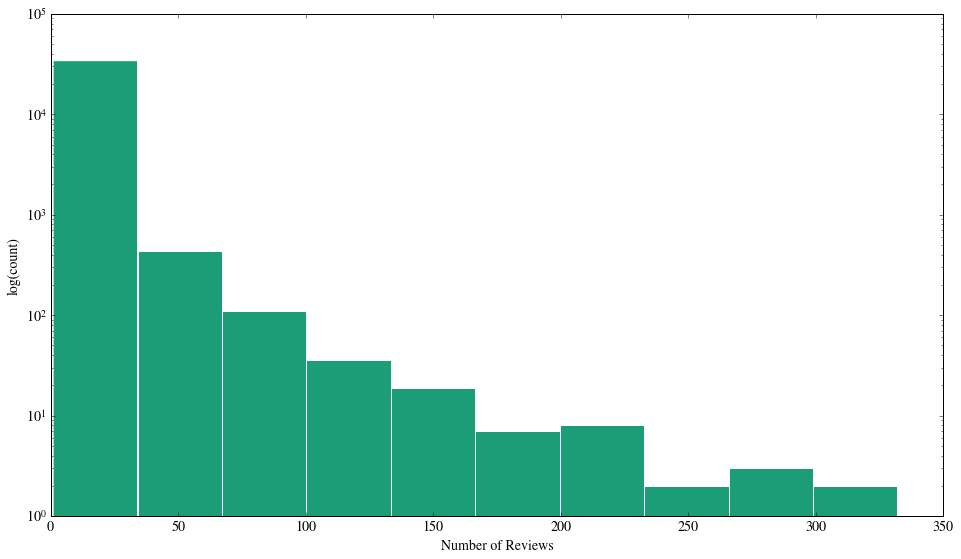

In [24]:
#your code here
plt.figure(figsize=(16,9))
plt.hist(fulldf.groupby('user_id').review_id.count(), log=True)
plt.title("Review Count Grouped by User")
plt.xlabel("Number of Reviews")
plt.ylabel("log(count)")
plt.show()

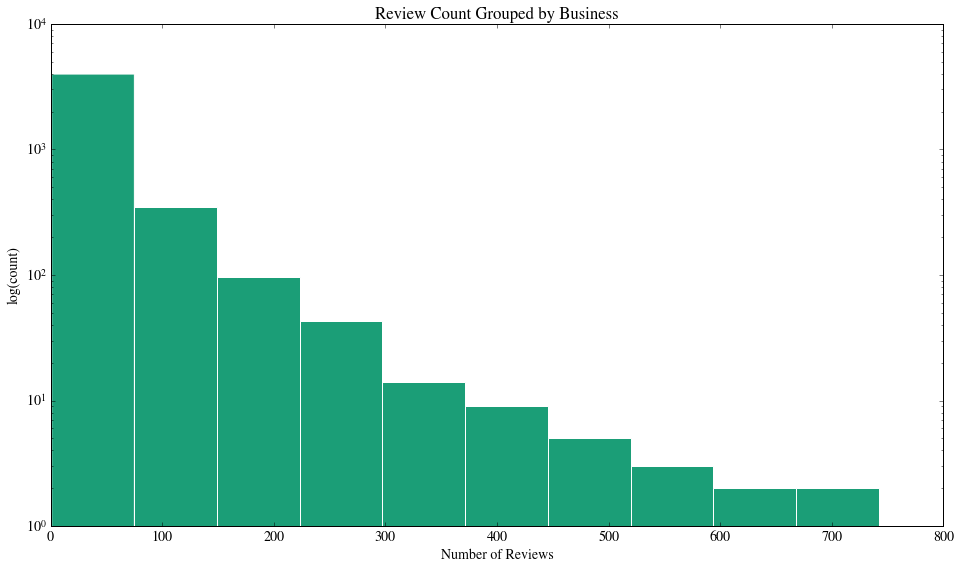

In [25]:
#your code here
plt.figure(figsize=(16,9))
plt.hist(fulldf.groupby('business_id').review_id.count(), log=True)
plt.title("Review Count Grouped by Business")
plt.xlabel("Number of Reviews")
plt.ylabel("log(count)")
plt.show()

In [19]:
#your code here
df_size = len(fulldf)
num_user = len(fulldf.user_id.unique())
num_reviews = len(fulldf.review_id.unique())
num_biz = len(fulldf.business_id.unique())
print("Number of rows: %d\nNumber of users: %d\nNumber of reviews: %d\nNumber or businesses: %d" % (df_size,num_user,num_reviews,num_biz))

if(num_user>num_biz):
    print("There are %d more users than businesses" % (num_user-num_biz))
else:
    print("There are %d more businesses than users" % (num_biz-num_user))

Number of rows: 149319
Number of users: 34789
Number of reviews: 149319
Number or businesses: 4503
There are 30286 more users than businesses


> There are more users than businesses and thus, more reviews per business than per user. From the histograms, I can see that there are more users that review little and more businesses that get few reviews.

**1.2** Compute the average rating of reviews in the data set and a histogram of all the ratings in the dataset.

Average rating: 3.74 stars


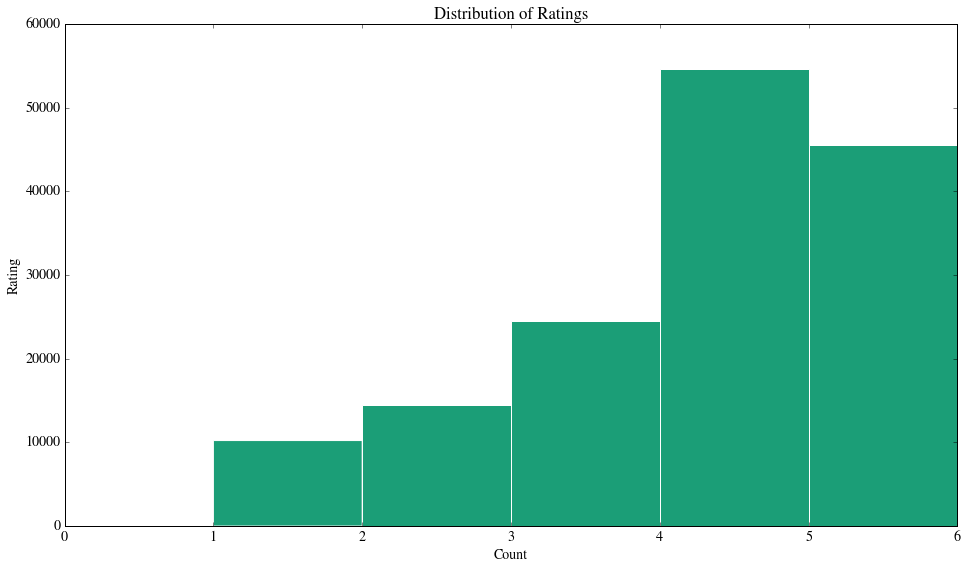

In [37]:
#your code here
print("Average rating: %.2f stars" % fulldf.stars.mean())
plt.figure(figsize=(16,9))
plt.hist(fulldf["stars"], bins=range(1,7))
plt.title("Distribution of Ratings")
plt.xlabel("Count")
plt.xticks(range(7))
plt.ylabel("Rating")
plt.show()

The following function is used to re-compute review counts and averages whenever you subset a reviews data frame. We'll use it soon to construct a smaller, more computationally tractable data frame.

In [38]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    nldf=ldf.copy()
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf

**1.3** Create a smaller data set in dataframe `smalldf` by looking for those businesses with more than 150 reviews and those users with more than 60 reviews. Include all the columns that were there in the parent dataframe. Since you have created a subset of the data set, use the method provided above to recalculate the averages. Print the number of unique users and items in this data set.  

Note that while this cut makes sure we have prolific users, the cut on businesses restores sparsity  by reducing the number of reviews per user.

In [67]:
#your code here
#df_60_150 = recompute_frame(fulldf[(fulldf['user_review_count'] > 60) | (fulldf['business_review_count'] > 150)])
smalldf = recompute_frame(fulldf[(fulldf['user_review_count'] > 60) & (fulldf['business_review_count'] > 150)])
print("There are %d unique users and %d unique businesses in this subset" % (len(smalldf.user_id.unique()), len(smalldf.business_id.unique())))

There are 240 unique users and 172 unique businesses in this subset


How does this compare to the parent data set, in terms of size and sparsity? Once again, plot histograms of the review count grouped by user, and by the review count grouped by business, respectively, and describe the results

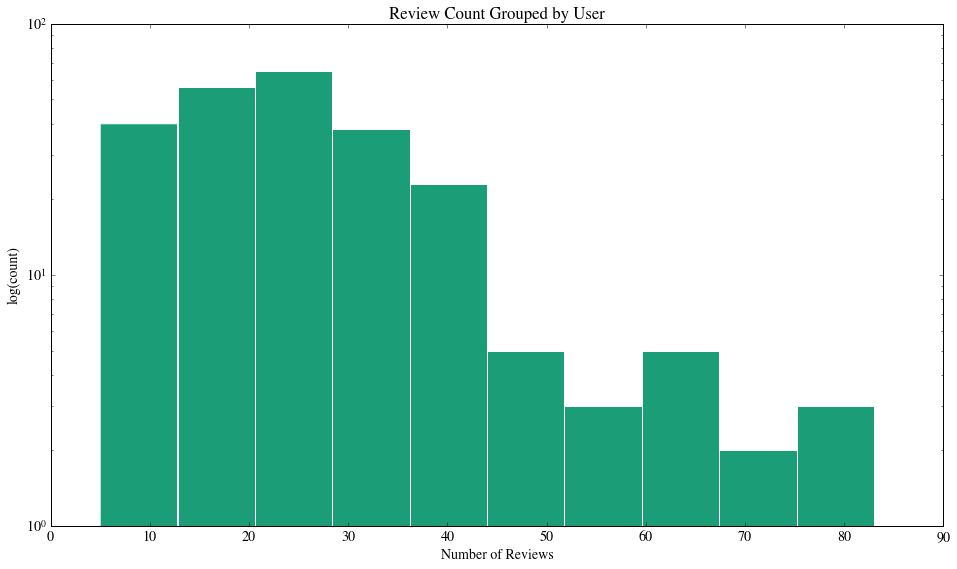

In [68]:
#your code here
plt.figure(figsize=(16,9))
plt.hist(smalldf.groupby('user_id').review_id.count(), log=True)
plt.title("Review Count Grouped by User")
plt.xlabel("Number of Reviews")
plt.ylabel("log(count)")
plt.show()

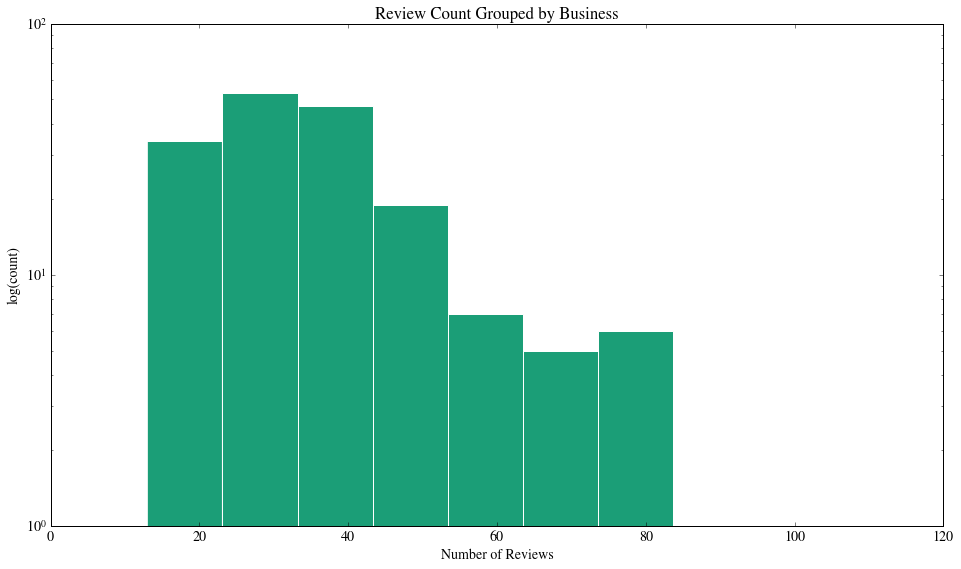

In [69]:
#your code here
plt.figure(figsize=(16,9))
plt.hist(smalldf.groupby('business_id').review_id.count(), log=True)
plt.title("Review Count Grouped by Business")
plt.xlabel("Number of Reviews")
plt.ylabel("log(count)")
plt.show()

> The set has been cut down to a smaller size and the review counts have been reduced. We are looking at only the users that actually review and the highly reviewed businesses that they have been to. The distribution of review counts isn't as sparce as in the full dataset. Both users and businesses have the majority of their review counts at 15-50. It isn't a normal distribution.

**1.4** Compute histograms of the average user rating in the smaller data set, and the average business rating in the smaller data set. Print the overall mean.

Average rating: 3.87 stars


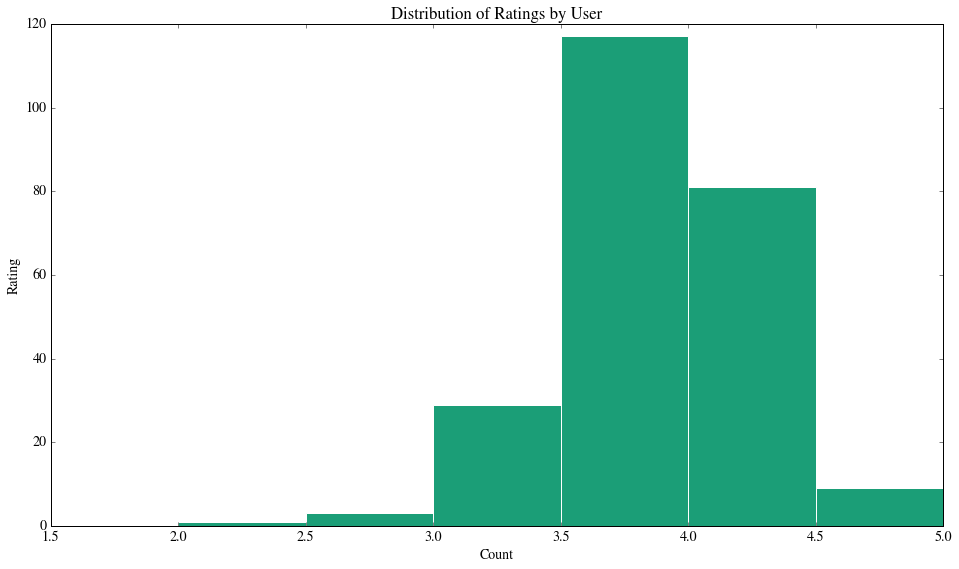

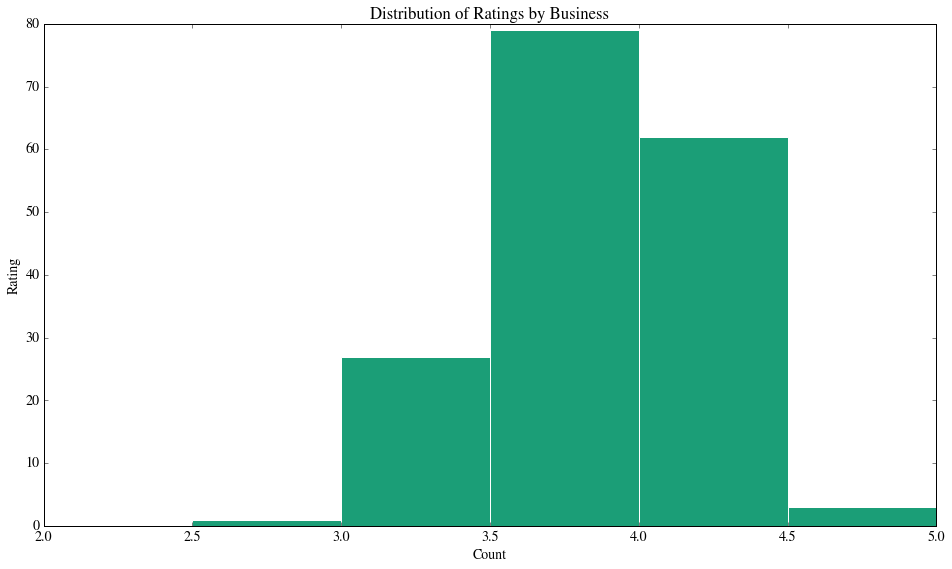

In [70]:
#your code here
print("Average rating: %.2f stars" % smalldf.stars.mean())
plt.figure(figsize=(16,9))
plt.hist(smalldf.groupby("user_id")["stars"].mean(), bins=[x/2 for x in range(3,11)])
plt.title("Distribution of Ratings by User")
plt.xlabel("Count")
plt.xticks([x/2 for x in range(3,11)])
plt.ylabel("Rating")
plt.show()

plt.figure(figsize=(16,9))
plt.hist(smalldf.groupby("business_id")["stars"].mean(), bins=[x/2 for x in range(4,11)])
plt.title("Distribution of Ratings by Business")
plt.xlabel("Count")
plt.xticks([x/2 for x in range(4,11)])
plt.ylabel("Rating")
plt.show()

### Common Support

Lets now make a histogram of the common user support (the number of common reviewers) of each pair of restaurants on the smaller set, and print the mean. Pay attention to the code, as you will use parts of it later. (This code takes a bit of time to run, so be patient).

The common support is an important concept, as for each pair of restaurants, its the number of people who reviewed both. It will be used to modify similarity between restaurants. If the common support is low, the similarity is less believable.

Mean support is: 6.84679722562


(array([  7.02000000e+03,   4.98700000e+03,   1.79400000e+03,
          5.90000000e+02,   1.95000000e+02,   7.60000000e+01,
          2.20000000e+01,   1.00000000e+01,   1.00000000e+01,
          2.00000000e+00]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ]),
 <a list of 10 Patch objects>)

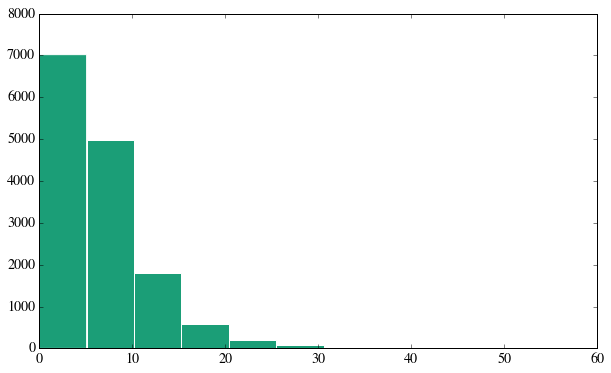

In [71]:
restaurants=smalldf.business_id.unique()
supports=[]
for i,rest1 in enumerate(restaurants):
    for j,rest2 in enumerate(restaurants):
        if  i < j:
            rest1_reviewers = smalldf[smalldf.business_id==rest1].user_id.unique()
            rest2_reviewers = smalldf[smalldf.business_id==rest2].user_id.unique()
            common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
            supports.append(len(common_reviewers))
print("Mean support is:",np.mean(supports))
plt.hist(supports)

As you can see, even though we chose a subset of the dataframe in which every restaurant had 150 reviews and every user had atleast made 60, the common support of most pairs of restaurants is really low, indeed less than 10!.

### Calculating Similarity

Users rate restaurants on a scale of 1-5. Even though this rating is integer valued, for the purposes of this assignment we shall treat it as a real number.

Even though each reviewer uses the same 5-star scale when rating restaurants, comparing two users by comparing their raw user ratings can be problematic. Consider a user whose average rating is 2. This is a curmudgeonly user. Consider another whose average rating is 4. This is a rather enthusiastic one. How should we compare a 3 rating by the curmudgeonly one to a 5 rating of the enthusiastic one?

It is for this purpose that we must subtract the average rating of the user from the actual rating of the restaurants in computing the similarity of two restaurants. This makes the above ratings by the two users comparable. We do this in the function `pearson_sim` defined below.

If there is no common support (`n_common=0`), we have no basis for making a similarity estimate, and so we set the similarity to 0. In the case that the individual restaurant rating variance is 0, such as in the case where there is only one common reviewer (`n_common=1`), we return the `NaN` that the scipy `pearsonr` returns. We will deal with it soon,

In [72]:
from scipy.stats.stats import pearsonr
def pearson_sim(rest1_reviews, rest2_reviews, n_common):
    """
    Given a subframe of restaurant 1 reviews and a subframe of restaurant 2 reviews,
    where the reviewers are those who have reviewed both restaurants, return 
    the pearson correlation coefficient between the user average subtracted ratings.
    The case for zero common reviewers is handled separately. Its
    ok to return a NaN if any of the individual variances are 0.
    """
    if n_common==0:
        rho=0.
    else:
        diff1=rest1_reviews['stars']-rest1_reviews['user_avg']
        diff2=rest2_reviews['stars']-rest2_reviews['user_avg']
        rho=pearsonr(diff1, diff2)[0]
    return rho

The function `get_restaurant_reviews` defined below takes a restaurant `business_id` and a set of users, and returns the reviews of that restaurant by those users. You will use this function in calculating a similarity function, in **1.5**.

In [73]:
def get_restaurant_reviews(restaurant_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.business_id==restaurant_id)
    reviews = df[mask]
    reviews = reviews[reviews.user_id.duplicated()==False]
    return reviews

**1.5** Write a function `calculate_similarity` that operates between two restaurants and calculates a similarity for them, taking a dataframe and a similarity function `similarity_func`. An example of the `similarity_func` is the `pearson_sim` we defined above. `calculate_similarity` operates as follows: 

1. For each of the two restaurants, get the set of reviewers who have reviewed the restaurant and compute the intersection of these two sets. Also compute the number of common reviewers `n_common`.

2. Use the function `get_restaurant_reviews` defined below to get the reviews for each restaurant as made by these common reviewers. Notice that `get_restaurant_reviews` returns a sub data frame of reviews.

3. Calculate the similarity using `similarity_func` which takes the two reviews dataframes from part 2 and the number of common reviewers `n_common` as arguments

4. Return the similarity and `n_common` in a tuple `(sim, n_common)`. If the similarity is a `NaN`, set the similarity to 0.


In [79]:
"""
Function
--------
calculate_similarity

Parameters
----------
rest1 : string
    The id of restaurant 1
rest2 : string
    The id of restaurant 2
df : DataFrame
  A dataframe of reviews, such as the smalldf above
similarity_func : func
  A function like pearson_sim above which takes two dataframes of individual
  restaurant reviews made by a common set of reviewers, and the number of
  common reviews. This function returns the similarity of the two restaurants
  based on the common reviews.
  
Returns
--------
A tuple
  The first element of the tuple is the similarity and the second the
  common support n_common. If the similarity is a NaN, set it to 0
"""
#your code here

def calculate_similarity(rest1, rest2, df, similarity_func):
    reviewers = set(df[df.business_id==rest1].user_id.values).intersection(
                set(df[df.business_id==rest2].user_id.values))
    n_common = len(reviewers)
    #kind of silly to call this, no?
    rest1DF = get_restaurant_reviews(rest1, df, reviewers)
    rest2DF = get_restaurant_reviews(rest2, df, reviewers)
    similarity = similarity_func(rest1DF,rest2DF, n_common)
    
    #apparently, NaN != NaN
    if similarity != similarity:
        similarity = 0
    return (similarity,n_common)

### Making a database of similarities

We now move to calculating a global database of pairwise restaurant similarities.
We provide you here with a function to make a database of the similarities for each pair of restaurants in the database. The class `Database` is initialized in its constructor by taking as arguments a dataframe of reviews. The method `populate_by calculating` iterates over every possible pair of business_id's in the dataframe and populates the database with similarities and common supports. It takes as arguments a function the similarity function `similarity_func` like `pearson_sim` (`calculate_similarity` then uses this to calculate the similarity). The `get` method on the database can be used to retrieve the similarity for two business ids.

In [80]:
class Database:
    "A class representing a database of similaries and common supports"
    
    def __init__(self, df):
        "the constructor, takes a reviews dataframe like smalldf as its argument"
        database={}
        self.df=df
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)
        
    def populate_by_calculating(self, similarity_func):
        """
        a populator for every pair of businesses in df. takes similarity_func like
        pearson_sim as argument
        """
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1 < i2:
                    sim, nsup=calculate_similarity(b1, b2, self.df, similarity_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                elif i1==i2:
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sim[i1][i1]=1.
                    self.database_sup[i1][i1]=nsup
                    

    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.uniquebizids[b1]][self.uniquebizids[b2]]
        nsup=self.database_sup[self.uniquebizids[b1]][self.uniquebizids[b2]]
        return (sim, nsup)

Lets run `make_database` and store the result in the global variable `db`. Lets print out an example entry. Running this function will take a bit of time.

In [81]:
db=Database(smalldf)
db.populate_by_calculating(pearson_sim)

In [82]:
db.get("z3yFuLVrmH-3RJruPEMYKw", "zruUQvFySeXyEd7_rQixBg")

(0.39904554525734559, 7)

### K-Nearest restaurants (in similarity)

We are now going to find the k-nearest restaurants to a given restaurant based on the database of similarities that we calculated. But we have a problem.

Consider the two cases where there is just one common reviewer, and where there are 40. In the former case, we might get a artificially high similarity based on the tastes of just this user, and thus we must reduce its importance in the nearest-neighbor calculation. In the latter case, we would get a much more unbiased estimator of the similarity of the two restaurants.

To control the effect of small common supports, we can **shrink** our pearson co-efficients. We shall do this by using the "regularization" parameter `reg`:

$$s_{mj} = \frac{N_{common}\, \rho_{mj}}{N_{common}+reg} $$

where $N_{common}$ (`n_common`) is the common reviewer support and $\rho_{ij}$ is the pearson co-relation coefficient.

Recall the notions of regularization introduced in class. We want to reduce the variance in our estimates, so we pull our estimates in toward a conservative point in a way that strongly corrals in estimates when there is very little data, but allows the data to speak when there is a lot. This can be shown as equivalent to adding in a `reg` amount of bayesian prior, as Joe has alluded to in class. 

A good value of the regularizer is intuitively one that doesn't affect the similarity when the common support is high ~10, but has a large effect when the support is small. In this case, values of 2-4 are good. Usually, the value of `reg` is determined using cross-validation, but for the sake of simplicity we will generally set it to 3.

We define a function `shrunk_sim` which takes the `sim` and `n_common` obtained from the database, and shrinks the similarity down using the regularizer `reg`.

In [83]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

**1.6** Now we can move to writing a `knearest` function, which finds the `k` nearest neighbors of a given restaurant based on the shrunk similarities we calculate. Note that as defined here, the nearest neighbors are global over the entire set of restaurants, as opposed to being restricted to the restaurants a user has reviewed(we shall do that in the next problem). Thus, this is an expensive function!

Write a `knearest` that returns a *k-length sorted list* of 3-tuples each corresponding to a restaurant. The tuple structure is `(business_id, shrunken similarity score, common support)` where the similarity score and common support are with respect to the restaurant whose neighbors we are finding, and the `business_id` is the id of the "nearby" restaurant found. The nearby restaurants are found from a supplied numpy array of restaurants `set_of_restaurants`. The spec for the function is given below. HINT: use `itemgetter` from the `operator` module to do the sorting.

In [99]:
"""
Function
--------
knearest

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
set_of_restaurants : array
    The set of restaurants from which we want to find the nearest neighbors
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""
#your code here
from operator import itemgetter
def knearest(restaurant_id, set_of_restaurants, dbase, k=7, reg=3):
    sims = [(rest_id,dbase.get(restaurant_id, rest_id)) for rest_id in set_of_restaurants if rest_id != restaurant_id]
    ssims = [(sim[0],shrunk_sim(*sim[1], reg), sim[1][1]) for sim in sims]
    return sorted(ssims, key=itemgetter(1), reverse=True)[:k]

### Ok it's time to recommend!

Lets choose the two very different businesses in the dataframe

In [85]:
testbizid="eIxSLxzIlfExI6vgAbn2JA"
testbizid2="L-uPZxooP_ziXCtRrWi8Pw"

We provide functions to look up a business name given a business id, and a username given a user id.

In [86]:
def biznamefromid(df, theid):
    return df['biz_name'][df['business_id']==theid].values[0]
def usernamefromid(df, theid):
    return df['user_name'][df['user_id']==theid].values[0]

In [87]:
print(testbizid, biznamefromid(smalldf,testbizid))
print(testbizid2, biznamefromid(smalldf, testbizid2))

eIxSLxzIlfExI6vgAbn2JA Lobbys Beef Burgers Dogs
L-uPZxooP_ziXCtRrWi8Pw Café Monarch


#### Get top matches

Its now time to answer the question: "if you liked this, you might also like these". We use our `testbizid` and `testbizid2` to compute the `k=7` nearest neighbors with a regularization of `3.` . We print these top 7 matches names, along with their similarity coefficient and common support.

In [92]:
tops=knearest(testbizid, smalldf.business_id.unique(), db, k=7, reg=3.)
print("For ",biznamefromid(smalldf, testbizid), ", top matches are:")
for i, (biz_id, sim, nc) in enumerate(tops):
    print(i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc)

For  Lobbys Beef Burgers Dogs , top matches are:
0 La Condesa Gourmet Taco Shop | Sim 0.598714448434 | Support 6
1 Citizen Public House | Sim 0.571428571429 | Support 4
2 FnB | Sim 0.527129890943 | Support 5
3 Defalco's Italian Grocery | Sim 0.519456555658 | Support 6
4 Republic Ramen + Noodles | Sim 0.519140146937 | Support 5
5 unPhogettable | Sim 0.5 | Support 3
6 Haus Murphy's | Sim 0.467637235308 | Support 3


In [94]:
tops2=knearest(testbizid2, smalldf.business_id.unique(), db, k=7, reg=3.)
print("For ",biznamefromid(smalldf, testbizid2), ", top matches are:")
for i, (biz_id, sim, nc) in enumerate(tops2):
    print(i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc)

For  Café Monarch , top matches are:
0 Postino Arcadia | Sim 0.625 | Support 5
1 The Main Ingredient Ale House And Café | Sim 0.571428571429 | Support 4
2 Brio Tuscan Grille | Sim 0.571428571429 | Support 4
3 Kazimierz World Wine Bar | Sim 0.5 | Support 3
4 Harlow's Cafe | Sim 0.5 | Support 3
5 The Fry Bread House | Sim 0.5 | Support 3
6 Cien Agaves Tacos & Tequila | Sim 0.5 | Support 3


We can see that these two restaurants are in somewhat different orbits :-).

Lets now turn our attention to another question: what are the top recommendations for a user? To answer this we must find the user's top rated restaurants, find the nearest neighbors of these restaurants, merge these lists while removing the duplicates and the ones that the user has already rated, and sort by the restaurant's average rating. We provide the code to get the user's top choices in a subset data frame.

In [96]:
def get_user_top_choices(user_id, df, numchoices=5):
    "get the sorted top 5 restaurants for a user by the star rating the user gave them"
    udf=df[df.user_id==user_id][['business_id','stars']].sort_values(by=['stars'], ascending=False).head(numchoices)
    return udf
testuserid="7cR92zkDv4W3kqzii6axvg"
print("For user", usernamefromid(smalldf,testuserid), "top choices are:")
bizs=get_user_top_choices(testuserid, smalldf)['business_id'].values
[biznamefromid(smalldf, biz_id) for biz_id in bizs]

For user Vern top choices are:


['Tee Pee Mexican Food',
 'Local Breeze',
 "Carly's Bistro",
 'District American Kitchen and Wine Bar',
 'Sonora Mesquite Grill']

#### Get top recommendations for user.

**1.7** Its your job now to write a function `get_top_recos_for_user` which takes as arguments a `userid`, the `n` top choices for the user, the dataframe, `k`, and a regularizer, and returns the top recommendations obtained from combining the restaurants that are neighbors of each of the `n` choices, in the way described in the previous paragraph. This returned list is a list of tuples `(restaurant_id, business_avg)` sorted by `business_avg` where `business_avg` is the average rating of the restaurant over the dataframe.

In [102]:
"""
Function
--------
get_top_recos_for_user

Parameters
----------
userid : string
    The id of the user for whom we want the top recommendations
df : Dataframe
    The dataframe of restaurant reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businesses. e.g. dbase.get(rid1,rid2)
n: int
    the n top choices of the user by star rating
k : int
    the number of nearest neighbors desired, default 8
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top recommendations. The list is a list of tuples
    (business_id, business_avg). You are combining the k-nearest recommendations 
    for each of the user's n top choices, removing duplicates and the ones the user
    has already rated.
"""
#your code here
def get_top_recos_for_user(userid, df, dbase, n, k=8, reg=3):
    top_n = get_user_top_choices(userid, df, n)["business_id"].values
    nknn = [recommend for biz_id in top_n for recommend in knearest(biz_id, df["business_id"].unique(), dbase, k, reg)]
    bizE = set([(biz_id, df[df.business_id == biz_id].stars.mean()) for biz_id,_,_ in nknn])
    return sorted(bizE, key=itemgetter(1), reverse=True)

Lets print the top recommendations for `testuserid`, with a regularization of 3.

In [103]:
print("For user", usernamefromid(smalldf,testuserid), "the top recommendations are:")
toprecos=get_top_recos_for_user(testuserid, smalldf, db, n=5, k=7, reg=3.)
for biz_id, biz_avg in toprecos:
    print(biznamefromid(smalldf,biz_id), "| Average Rating |", biz_avg)

For user Vern the top recommendations are:
Rokerij | Average Rating | 4.379310344827586
Petite Maison | Average Rating | 4.357142857142857
Wildfish Seafood Grille | Average Rating | 4.294117647058823
Defalco's Italian Grocery | Average Rating | 4.232558139534884
Cornish Pasty Company | Average Rating | 4.206896551724138
Pappadeaux Seafood Kitchen | Average Rating | 4.185185185185185
Four Peaks Brewing Co | Average Rating | 4.166666666666667
Yasu Sushi Bistro | Average Rating | 4.076923076923077
Pho Thanh | Average Rating | 4.0476190476190474
Local Breeze | Average Rating | 4.0
Pita Jungle | Average Rating | 3.911764705882353
Carolina's Mexican Food | Average Rating | 3.911764705882353
The Main Ingredient Ale House And Café | Average Rating | 3.8974358974358974
Malee's Thai Bistro | Average Rating | 3.875
Butterfield's Pancake House | Average Rating | 3.8333333333333335
Joe's Real BBQ | Average Rating | 3.8157894736842106
Arcadia Farms Cafe | Average Rating | 3.793103448275862
Delux | A

## Problem 2: A user based recommender with predicted ratings

This is all very nice. We can provide ratings based on global similarities to a restaurant. However, in many cases this is not enough.

For example, it is hard to judge if the above recommendations are any good. In the usual testing paradigm, say that we break the dataframe into train and test. Based on the training set, I am recommended restaurant B. Now, I have rated B, but that information is in the testing set. I have no way of comparing the rating I give B in the testing set, to the similarity computed from the training set that was used to make the recomendation. The best I could do is to compare the average rating of restaurant B in the training set to my rating of restaurant B in the test set. 

In this section, we shift our focus to more fine-grained predictions about each user, and try to predict what _rating_ a user would give to a restaurant they have never tried before. To do this, we will try to personalize the information we use even further, and only pool information from restaurants that the user has rated.

This allows us to return to the original problem of prediction $Y_{um}$ for a restaurant $m$ that user $u$ has never rated before. Using our newly computed similarity metrics, we can modify our original baseline estimate by pulling in information from the user's neighborhood of the restaurant $m$, and predict $Y_{um}$ as:

$$ \hat{Y_{um}} = \hat Y^{baseline}_{um}\, + \,\frac{\sum\limits_{j \in S^{k}(m;u)} s_{mj} ( Y_{uj} - \hat Y^{baseline}_{uj} )}{\sum\limits_{j \in S^{k}(m;u)} s_{mj} } $$

where $s^{k}(m;u)$ is the $k$ neighbor items of item $m$ which have been rated by user $u$.

Now, this is not a particularly good assumption, especially in the situation where a restaurant is new (new item problem) or a user is new (cold start problem), or in the case when there are very few reviewers of a restaurant, or very few reviews by a user respectively. However, one must start somewhere!

Notice that in adding in the similarity term, we subtract the baseline estimate from the observed rating of the user's neighbor items.

### Defining the predicted rating

**2.1** Write a function `knearest_amongst_userrated`, analogous to the `knearest` function we defined above, to find the nearest `k` neighbors to a given restaurant from the **restaurants that the user has already rated**. This function will take as arguments the `restaurant_id`, the `user_id`, the dataframe of reviews, the database, the `k`, and the regularizer `reg`. Just like before, return a *k-length sorted list* of 3-tuples each corresponding to a restaurant.  HINT: use the `knearest` function you defined earlier

In [106]:
"""
Function
--------
knearest_amongst_userrated

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
df: Dataframe
    The dataframe of reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""
#your code here
def knearest_amongst_userrated(restaurant_id, user_id, df, dbase, k=7, reg=3):
    return knearest(restaurant_id, df[df.user_id == user_id].business_id.unique(), dbase, k, reg)

**2.2** Now write a function that returns the predicted rating for a user and an item using the formula at the beginning of this problem. Include code to deal with the possibility that the sum of scores that goes in the denominator is 0: return a predicted rating of the baseline portion of the formula in that case. This function `rating` takes as arguments the dataframe, the database, the wanted `restaurant_id` and `user_id`, and `k` as well as the regularizer.

In [110]:
"""
Function
--------
rating

Parameters
----------
df: Dataframe
    The dataframe of reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A float
    which is the impued rating that we predict that user_id will make for restaurant_id
"""
def y_hat_baseline(user_id, business_id, df):
    y = df.stars.mean()
    y_u = df[df.user_id == user_id].stars.mean()
    y_m = df[df.business_id == business_id].stars.mean()
    return  y+(y_u-y)+(y_m-y)
    
def y_uj(user_id, business_id, df):
    #should only be 1 element... but who knows?
    return df[(df['business_id'] == business_id) & (df['user_id'] == user_id)].stars.mean()

#your code here
def rating(df, dbase, restaurant_id, user_id, k=7, reg=3):
    y_hat_baseline_um = y_hat_baseline(user_id, restaurant_id, df)
    
    knns = knearest_amongst_userrated(restaurant_id, user_id, df, dbase, k, reg)
    sum_S_mj = sum([knn[1] for knn in knns])
    
    if sum_S_mj == 0:
        return y_hat_baseline_um # + inf?
    
    #sum_S_mj != 0. compute numerator now
    numerator = sum([knn[1]*(y_uj(user_id, knn[0], df) - y_hat_baseline(user_id, knn[0], df)) for knn in knns])
    
    return y_hat_baseline_um + numerator/sum_S_mj

For the top-recommendations in the variable `toprecos` from the previous section, we compute the predicted rating and compare it with the average rating over all users available inside the tuples that make up `toprecos`. We use a `k` of 7 and regularization 3. For comparision we also print this users' average rating. Do you notice anything interesting about how the order has changed from when we did this with the global similarities? (for you to think, not to answer)

In [111]:
print("User Average", smalldf[smalldf.user_id==testuserid].stars.mean(),"for",usernamefromid(smalldf,testuserid))
print("Predicted ratings for top choices calculated earlier:")
for biz_id,biz_avg in toprecos:
    print(biznamefromid(smalldf, biz_id),"|",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.),"|","Average",biz_avg) 

User Average 3.5652173913043477 for Vern
Predicted ratings for top choices calculated earlier:
Rokerij | 4.71714023074 | Average 4.379310344827586
Petite Maison | 4.02414814442 | Average 4.357142857142857
Wildfish Seafood Grille | 4.27594504172 | Average 4.294117647058823
Defalco's Italian Grocery | 3.822223075 | Average 4.232558139534884
Cornish Pasty Company | 4.62810510121 | Average 4.206896551724138
Pappadeaux Seafood Kitchen | 4.08845573953 | Average 4.185185185185185
Four Peaks Brewing Co | 4.26174734161 | Average 4.166666666666667
Yasu Sushi Bistro | 4.61103444018 | Average 4.076923076923077
Pho Thanh | 4.10317798035 | Average 4.0476190476190474
Local Breeze | 4.2280987611 | Average 4.0
Pita Jungle | 4.40378787384 | Average 3.911764705882353
Carolina's Mexican Food | 4.31700962152 | Average 3.911764705882353
The Main Ingredient Ale House And Café | 3.88743659505 | Average 3.8974358974358974
Malee's Thai Bistro | 4.39994642565 | Average 3.875
Butterfield's Pancake House | 3.77611

### Testing the ratings

Let us compare the predicted ratings with a user's ratings. Note that we are doing this on the same set that we constructed the predictions with, so this is not a validation of the procedure, but simply a check of the procedure's fit. We first write a helper function to return the user score for a restaurant, and the restaurant's average score over all users.

In [112]:
def get_other_ratings(restaurant_id, user_id, df):
    "get a user's rating for a restaurant and the restaurant's average rating"
    choice=df[(df.business_id==restaurant_id) & (df.user_id==user_id)]
    users_score=choice.stars.values[0]
    average_score=choice.business_avg.values[0]
    return users_score, average_score

For the user `testuserid`, we loop over the variable `bizs` (which is a set of restaurants the user has rated) and print the predicted rating, and the actual rating and restaurant average rating obtained using the function above. We again use `k=7` and a regularization of 3.

In [115]:
print("for user",usernamefromid(smalldf,testuserid), 'avg', smalldf[smalldf.user_id==testuserid].stars.mean())
for biz_id in bizs:
    print("----------------------------------")
    print(biznamefromid(smalldf, biz_id))
    print("Predicted Rating:",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.))
    u,a=get_other_ratings(biz_id, testuserid, smalldf)
    print("Actual User Rating:",u,"Avg Rating",a)

for user Vern avg 3.5652173913043477
----------------------------------
Tee Pee Mexican Food
Predicted Rating: 3.52640184162
Actual User Rating: 5 Avg Rating 3.04347826087
----------------------------------
Local Breeze
Predicted Rating: 4.2280987611
Actual User Rating: 5 Avg Rating 4.0
----------------------------------
Carly's Bistro
Predicted Rating: 3.99008654065
Actual User Rating: 5 Avg Rating 3.5
----------------------------------
District American Kitchen and Wine Bar
Predicted Rating: 3.80281696528
Actual User Rating: 4 Avg Rating 3.55263157895
----------------------------------
Sonora Mesquite Grill
Predicted Rating: 4.08382083034
Actual User Rating: 4 Avg Rating 4.38461538462


**2.3** Explain in words why the predicted ratings are lower than the actual ratings. How do the user average rating and restaurant average rating affect this? How does sparsity affect the predicted ratings?

> # _TODO_

### Error Analysis

This next function takes a set of actual ratings, and a set of predicted ratings, and plots the latter against the former. We can use a graph of this kind to see how well or badly we do in our predictions. Since the nearest neighbor models can have alternating positive and negative similarities (the sum of similarity weights in the denominator can get large), the ratings can get very large. Thus we restrict ourselves to be between -10 and 15 in our ratings and calculate the fraction within these bounds. We also plot the line with unit slope, line segments joining the means, and a filled in area representing one standard deviation from the mean.

The first argument to `compare_results` is a numpy array of the actual star ratings obtained from the dataframe, while the second argument is the numpy array of the predicted ones. (*Feel free to improve this function for your display*)

In [129]:
def compare_results(stars_actual, stars_predicted, ylow=-10, yhigh=15, title=""):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    
    fig=plt.figure(figsize=(16,9))
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    ax=plt.scatter(df.actual, df.predicted, alpha=0.2, s=30, label="predicted")
    plt.ylim([ylow,yhigh])
    plt.plot([1,5],[1,5], label="slope 1")
    xp=[1,2,3,4,5]
    yp=df.groupby('actual').predicted.mean().values
    plt.plot(xp,yp,'k', label="means")
    sig=df.groupby('actual').predicted.std().values
    plt.fill_between(xp, yp - sig, yp + sig, 
                 color='k', alpha=0.2)
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.legend(frameon=False)
    remove_border()
    plt.grid(False)
    plt.title(title)
    plt.show()
    print (np.mean(np.abs(df.predicted) < 15))


**2.4** For each review in the data set, obtain a prediction from the entire dataframe `smalldf`. Use the function `compare_results` above to plot the predicted ratings against the observed ones. Make 4 such graphs, at k=3 and k=10, and for reg=3. and reg=15.

Note that this analysis is not strictly a model check because we are testing on the training set. However, since the user averages would change each time a cross-validation split was done on the set, we would incur the prohibitive expense of redoing the database each time. This would be better done on a cluster, using map-reduce or other techniques. While we explore map-reduce later in this homework, we shall not do any cross-validation.

Explain the results you get in the graphs in words.

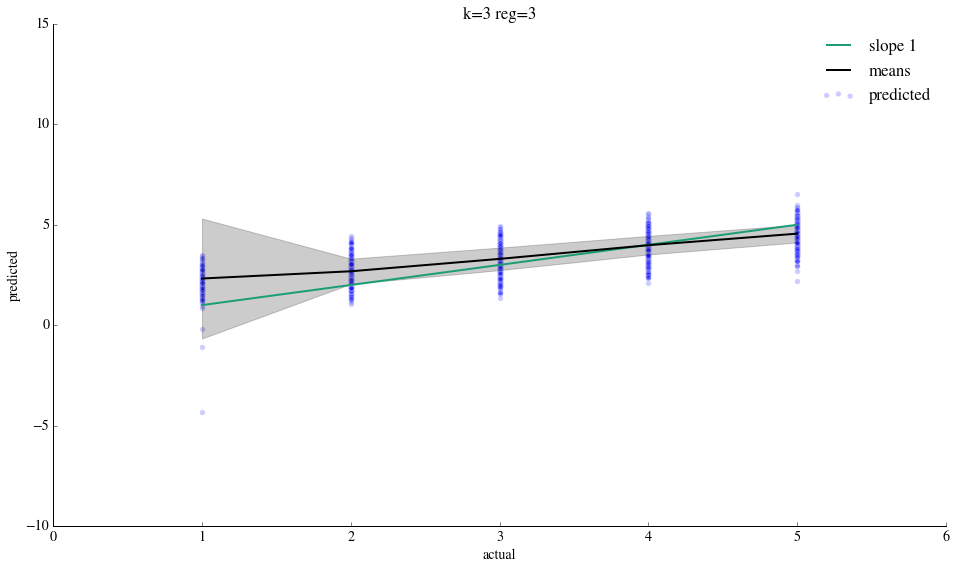

0.999837793998


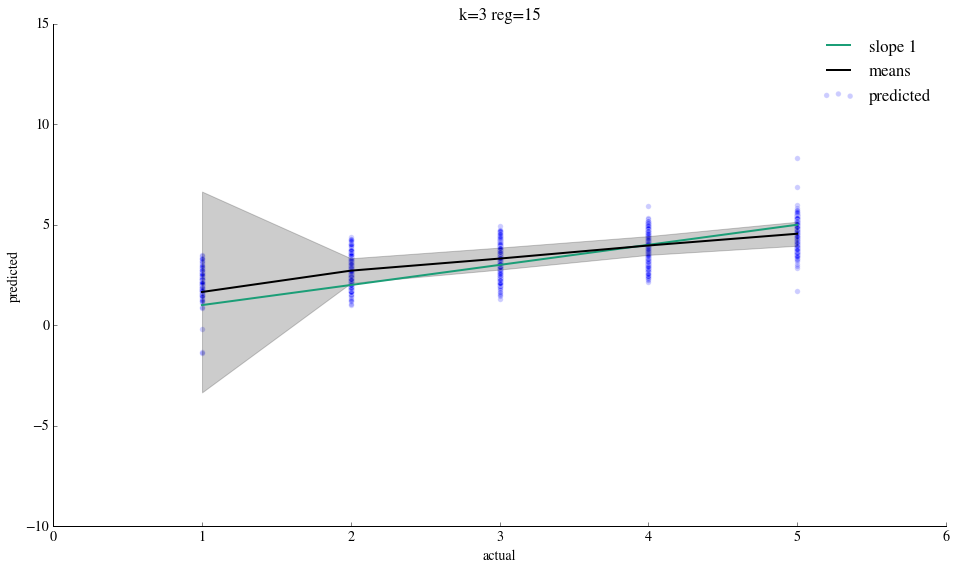

0.999675587997


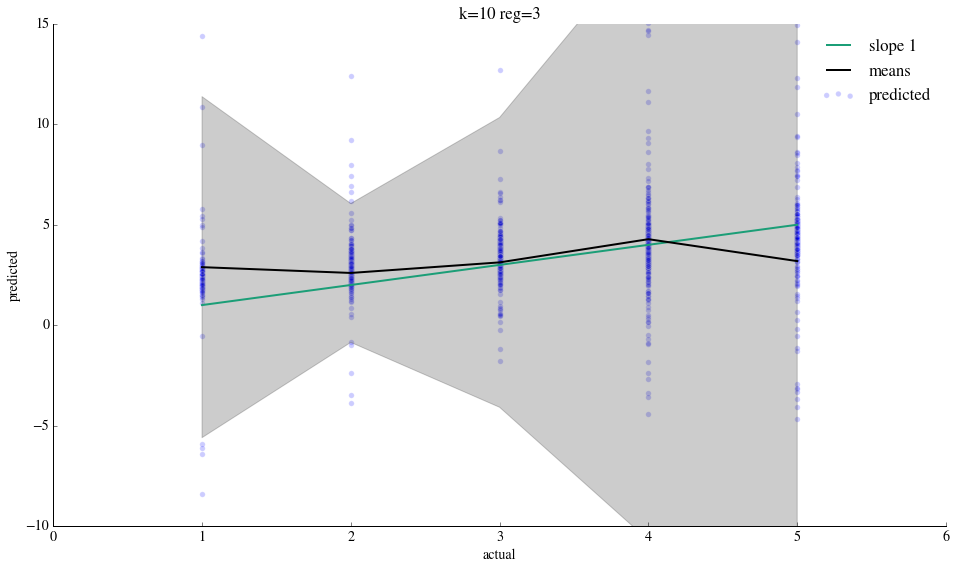

0.993349553933


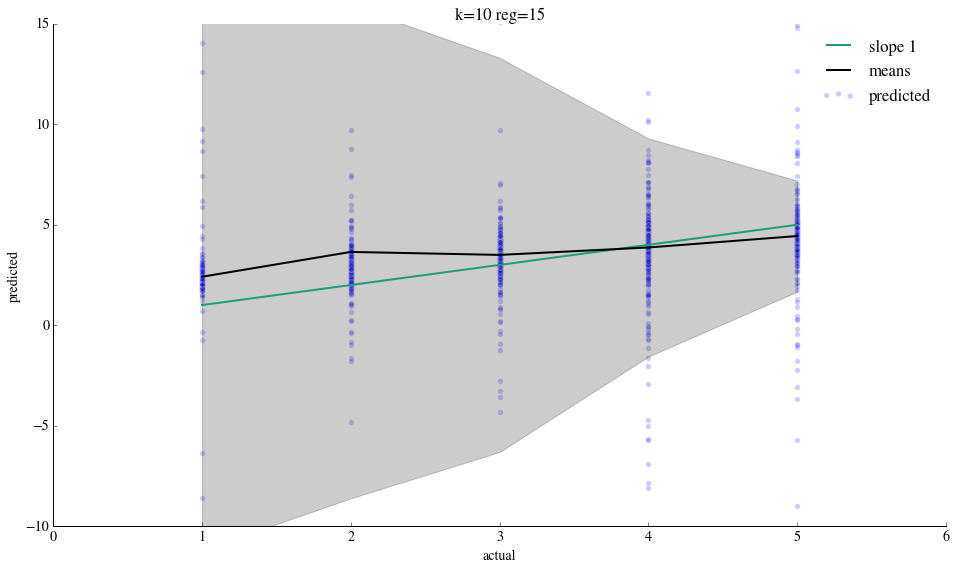

0.994484995945


In [130]:
#your code here
K = [3,10]
REG = [3,15]

rows = list(zip(smalldf['business_id'],smalldf['user_id']))
for k in K:
    for reg in REG:
        predicted = [rating(smalldf, db, row[0], row[1], k=k, reg=reg) for row in rows]
        compare_results(smalldf.stars, predicted, title=("k=%d reg=%d" % (k,reg)))

> # _TODO_

**2.5** Outline a process, in words, for choosing the nearest neighbor parameter `k`. For this question fix the regularization parameter `reg` at `3`.

> # _TODO_

## Q3 Bayesian Chocolates: Model based recommendations

In this part of the homework, you will use your newly minted Bayesian and Gibbs sampler skills to write a recommender that uses Bayesian techniques to impute ratings.

### Model-Based Recommendations


#### A Note on Frequentist and Bayesian Procedures

In the previous section we implemented a **procedure** (a set of instructions for processing data) for giving recommendations and predicting user ratings for restaurants. This procedure involved a number of arbitrary choices -- for example, the particular measure of similarity between restaurants, or the weighting scheme for constructing a predicted rating. It also gave no sense of uncertainty -- in the case of giving recommendations, there was no statement about how we would expect the ranking from the procedure to compare to the user's true opinions of restaurants, and in the case of predicting ratings, there was no confidence interval for the prediction.

It is possible in repeated applications of the above procedure to see how it performs in the long run. Based on this long-run performance we could potentially justify certain functional choices and compute measurements of uncertainty. This framework of proposing a procedure first, then evaluating its performance in real or hypothetical replications of the experiment is an example of a *frequentist* approach to a problem. One aspect of the frequentist approach is that the proposed procedure does not necessarily have to be derived from a model (although it often is). While this means that a proposed procedure may be more flexible or robust than a model-based procedure, it also means that there is no natural way to justify certain functional choices or construct uncertainty estimates.

In contrast, the *Bayesian* approach to a problem always begins with a **probablistic model** for how the data were generated. Assuming this model is true, the posterior distribution over unknown quantities (either parameters to be estimated or unobserved data to be predicted) gives a single coherent expression of what the observed data tell us about the unknowns. By summarizing the posterior distribution, we can derive the exact functional form of a procedure for constructing estimates or predictions. We call a procedure derived from this Bayesian approach a **Bayes rule** (not to be confused with Bayes' Theorem). Using the posterior distribution, we can also give a sense of how uncertain we are about the estimate or prediction we have constructed.

#### Outline for this Problem

In this section, we construct a **model** of how ratings are generated, and use this model to build a recommendation and ratings prediction system. We will take a Bayesian approach here, and construct our estimates and predictions from summaries of the *posterior distribution* of the model's parameters, which we will compute using a *Gibbs sampler*. We will also give measures of uncertainty based on the posterior distribution. We will evaluate predictions from this approach in the same way we evalutated predictions from the KNN procedure above.

### The Latent Factor Model ###

#### Model Overview ####

The central dogma in constructing a recommendation system using collaborative filtering is that *similar users will rate similar restaurants similarly*. In the previous section, we explicitly encoded this idea by using a similarity function to identify similar restaurants. We also assumed that either all users were the same (the global approach) or that only the current user was similar enough to make a recommendation (the user-specific approach). In this section, we will use a model that allows us to identify both similar users and similar restaurants as a function of **latent factors**.

We can think of latent factors as properties of restaurants (e.g., spiciness of food or price) that users have a positive or negative preference for. We do not observe these factors or the users' preferences directly, but we assume that they affect how users tend to rate restaurants. For example, if a restaurant serves a lot of spicy food and a user dislikes spicy food, then the restaurant would have a high "spiciness" factor, and the user would have a strongly negative preference, resulting in a prediction of a low rating. Note that if users have similar preferences, then according to the model, they will behave similarly, and likewise, if restaurants have similar latent factors, they will be rated similarly by similar users. Latent factors thus give us an intuitive way to specify a generative model the obeys the central dogma.

One issue that comes up with latent factor models is determining how many latent factors to include. There may be a number of different unmeasured properties that affect ratings in different ways -- for example, in addition to the spiciness factor above, there may also be a price factor that affects how users rate a restaurant. We deal with the problem of choosing the number of latent factors to include in the same way we deal with choosing $K$ in a $K$-nearest neighbors problem.

#### Rating Model Specification ####

To make this model concrete, we can write down our probability model as a generative process. First, we define the following quantities:

Counts:

* $L$: The number of latent factors.

* $U$: The number of users.

* $M$: The number of items (restaurants).

* $N$: The number of observed ratings.

Data:

* $Y_{um}$: The star rating given to restaurant $m$ by user $u$.
* $Y$: The full collection of observed star ratings.

Item-specific quantities:

* $\gamma_m$: An item-specific parameter vector of length $L+1$. The first element of $\gamma_m$, denoted $\gamma_m[0]$ is the item-specific bias. The remaining $L$ elements of $\gamma_m$, denoted $\gamma_m[1:]$, are the latent factors associated with item $m$.

* $\Gamma$: An $M$ by $L+1$ matrix where the $m$th row is $\gamma_m$.

User-specific quantities:

* $\theta_u$: A user-specific parameter vector of length $L+1$. The first element of $\theta_u$, denoted $\theta_u[0]$ is the user-specific bias. The remaining $L$ elements of $\theta_u$, denoted $\theta_u[1:]$, are user $u$'s preferences for the latent factors.

* $\Theta$: A $U$ by $L+1$ matrix where the $u$th row is $\theta_u$.

Global quantities:

* $\mu$: The overall ratings mean.

* $\sigma$: The residual variance of ratings after the mean, bias terms, and latent factors have been taken into account.

Using these quantities, we can specify our model for each rating $Y_{um}$ similarly to a linear regression:

$$Y_{um} = \mu + \theta_{u}[0] + \gamma_{m}[0] + \theta_{u}[1:]^{\top}\gamma_{m}[1:] + \epsilon_{um}$$

where

$$\epsilon_{um} \sim N(0, \sigma).$$

Note that while this looks like a linear regression, it is of a slightly different form because the latent factor term involves the product of two unknowns. This is like a linear regression where we forgot to measure some covariates.

We also assume the following priors on the user-specific and item-specific parameters:

$$
\begin{align*}
\gamma_m &\sim MVN(\mathbf 0, \Lambda_\gamma^{-1})\\
\theta_u &\sim MVN(\mathbf 0, \Lambda_\theta^{-1}),
\end{align*}
$$

where $MVN$ means multivariate normal, $\mathbf 0$ is vector of length $L+1$ filled with zeros, and $\Lambda_\theta^{-1}$ and $\Lambda_\gamma^{-1}$ are $L+1 \times L+1$ covariance matrices. $\mu$ and $\sigma$ also have priors, but they are not relevant to your task so we won't write them here.

#### Goal for this Model ####
Using this model, we want to make inference about all of the quantities that, if we knew them, would allow us to sample $Y_{um}$ for any user and any item. These quantities are $\mu$, $\sigma$, and the elements of $\Theta$ and $\Gamma$.

**3.1**: Given the goal specified above, how many quantities (counting a vector of $L$ items as $L$ quantities) are we trying to make inference about? Express your answer in terms of the variables in the "Counts" section above.

*your answer here*

### Gibbs Sampling from the Posterior ###

Our goal is to compute the **posterior distribution** over the unknowns $\mu$, $\sigma$, $\Gamma$, and $\Theta$ given $Y$, which reflects how much we know about these quantities given the data we have observed. We write this distribution as $P(\mu, \sigma, \Gamma, \Theta \mid Y)$.

The most general way to learn about the posterior distribution is to sample from it. This can be challenging, particularly in problems that are very high dimensional (see your answer to the question above). One strategy for for sampling from high-dimensional distributions is **Gibbs sampling**.

Gibbs sampling breaks down the posterior probability distribution into blocks of unknowns, and samples iteratively from each block assuming that the values of the other blocks (and the data) are known and fixed. In this case, we will break down the posterior distribution into blocks of $\mu$, $\sigma$, each vector $\gamma_m$, and each vector $\theta_u$. We have already implemented the draws for $\mu$ and $\sigma$. You will need to implement the draws for each $\gamma_m$ and each $\theta_u$. Luckily, the structures of these draws are similar, so you will only need to implement two functions.

First, we'll derive the form of the draws below. Note that you don't need to be able to follow these derivations fully -- you'll just need to be able to use the result at the end.

#### Distribution of $\gamma_{m'}$ given $Y, \mu, \sigma, \Gamma_{-m'}, \Theta$ ####

Intuitively, this is the distribution of the item-specific parameters for item $m'$, imagining that all of the other unknowns are fixed.

More precisely, we want to draw from the distribution of $\gamma_{m'}$ conditional on the data $Y$ and all other unknowns -- that is, $\mu$, $\sigma$, all of $\Theta$, and all of $\Gamma$ except for $\gamma_{m'}$, which we denote $\Gamma_{-m}$.

Note that in the model specification above, the only places that $\gamma_{m'}$ appears are in the regression equations for each $Y_{um}$ that involves item $m'$. If we write out just these equations, we get a system of the following form,

$$Y_{um'} = \mu + \theta_{u}[0] + \gamma_{m'}[0] + \theta_{u}[1:]^{\top}\gamma_{m'}[1:] + \epsilon_{um'},$$

with one equation for each $u$ that rated item $m'$. Now, because 

If we move all of the fully known terms to the left-hand side, we obtain the system:

$$Y_{um'} - \mu - \theta_{u}[0] = \gamma_{m'}[0] + \theta_{u}[1:]^{\top}\gamma_{m'}[1:] + \epsilon_{um'}.$$

Notice that, because we assume that $\theta_{u}$ is known, this equation now fits cleanly into the form of a linear regression, where $\gamma_{m'}$ is the vector of unknown coefficients. This means that the posterior distribution for $\gamma_{m'}$ conditional on everything else is the same as the posterior for the coefficients of a Bayesian linear regression of $(Y_{um'} - \mu - \theta_{u}[0])$ on $\theta_{u}[1:]$ and an intercept.

Let's denote the set of users who rated item $m'$ as $(u_1, \cdots, u_g)$. Then, we can define the following vector and matrix:

\begin{align*}
Y_{m'} = \left(\begin{array}{c} Y_{u_1m'}-\mu-\theta_{u_1}[0]\\ \vdots \\ Y_{u_gm'}-\mu-\theta_{u_g}[0]\end{array}\right), \qquad
X_{m'} &= \left(\begin{array}{cc} 1 & \theta_{u_1}[1:]^\top \\ \vdots & \vdots \\ 1 & \theta_{u_g}[1:]^\top\end{array}\right),
\end{align*}

where $Y_{m'}$ is a vector of length $g$ and $X_{m'}$ is a $g \times L+1$ matrix.

The draw from $\gamma_{m'}$ given everything else then has the form:
$$ \gamma_{m'} \mid Y, \mu, \sigma, \Gamma_{-m'}, \Theta \sim MVN\left(Q_{m'}^{-1} \frac{1}{\sigma^2}X_{m'}^\top Y_{m'}, Q_{m'}^{-1}\right)$$
where
$$ Q_{m'} = \left(\frac{1}{\sigma^2}X_{m'}^\top X_{m'} + \Lambda_\gamma\right).$$

#### Distribution of $\theta_{u'}$ given $Y, \mu, \sigma, \Gamma, \Theta_{-u'}$####

Intuitively, this is the distribution of the user-specific parameters for user $u'$, imagining that all of the other unknowns are fixed.

We can use a very similar argument to the one above. We can denote the set of items rated by user $u'$ as $(m_1, \cdots, m_g)$ and define the vector and matrix:
\begin{align*}
Y_{u'} = \left(\begin{array}{c} Y_{u'm_1}-\mu-\gamma_{m_1}[0] \\ \vdots \\ Y_{u'm_g}-\mu-\gamma_{m_g}[0]\end{array}\right), \qquad
X_{u'} &= \left(\begin{array}{cc} 1 & \gamma_{m_1}[1:]^\top \\ \vdots & \vdots \\ 1 & \gamma_{m_g}[1:]^\top\end{array}\right),
\end{align*}

where $Y_{u'}$ is a vector of length $g$ and $X_{u'}$ is a $g \times L+1$ matrix.

the draw from $\theta_{u'}$ given everything else has the form:
$$ \theta_{u'} \mid Y, \mu, \sigma, \Gamma, \Theta_{-u'} \sim MVN\left(Q_{u'}^{-1} \frac{1}{\sigma^2}X_{u'}^\top Y_{u'}, Q_{u'}^{-1}\right)$$
where
$$ Q_{u'}= \left(\frac{1}{\sigma^2}X_{u'}^\top X_{u'} + \Lambda_\theta\right).$$

**3.2** We will only ask you to implement a tiny portion of the Gibbs sampler. Complete the following functions that implement the conditional posterior draws for $\gamma_m$ and $\theta_u$ derived above.

**Hint**: `np.random.multivariate_normal` is a good function to know.

In [36]:
"""
Function
--------
gamma_m_draw

Draw a single sample from the conditional posterior distribution
of gamma_m.

Inputs
-------
X_m: A g-by-L+1 matrix, defined above. 
Y_m: A 1D vector of length g, defined above.
sig2: Residual _variance_, as defined above.
Lambda_gamma: Prior precision matrix.

Outputs
--------
Single draw from conditional posterior, defined above.
"""
#Item-specific parameters given all else
#your code here


In [37]:
"""
Function
--------
theta_u_draw

Draw a single sample from the conditional posterior distribution
of gamma_m.

Inputs
-------
X_u: A g-by-L+1 matrix, defined above. 
Y_u: A 1D vector of length g, defined above.
sig2: Residual _variance_, as defined above.
Lambda_theta: Prior precision matrix.

Outputs
--------
Single draw from conditional posterior, defined above.
"""
#User-specific parameters given all else
#your code here


Here is the Gibbs sampler skeleton that your functions fit into. Look over the structure to see how for each draw from the posterior, the sampler iterates through $\mu$, $\sigma$, $\gamma_m$ for each item, and $\theta_u$ for each user.

In [38]:
"""
Function
--------
factor_gibbs

Runs a gibbs sampler to infer mean, variance, user-specific, and item-specific
parameters.

Inputs
-------
data: A dataframe containing ratings data.
L: Dimension of latent factors.
maxit: Number of samples to draw from posterior.
Lambda_theta_diag: Hyperparameter controlling regularization of Theta.
Lambda_gamma_diag: Hyperparameter controlling regularization of Gamma.
progress: if true, print iteration number every 100 iterations.

Outputs
--------
Dictionary with elements
mu: Draws of mu. 1D array of length maxiter.
sig2: Draws of sig2, residual _variance_. 1D array of length maxiter.
theta: Draws of Theta. U-by-L-by-maxiter array.
gamma: Draws of Gamma. M-by-L-by-maxiter array.
EY: Draws of fitted values of Y. N-by-maxiter array.
"""
def factor_gibbs(data, L, maxit, Lambda_theta_diag, Lambda_gamma_diag, progress=True):
    data = data.copy()
    N = data.shape[0]

    #Create indices that allow us to map users and restaurants to rows
    #in parameter vectors.
    uusers, uidx = np.unique(data.user_id, return_inverse=True)
    uitems, midx = np.unique(data.business_id, return_inverse=True)

    nusers = uusers.size
    nitems = uitems.size

    #Add numerical indices to dataframe.
    data["uidx"] = uidx
    data["midx"] = midx

    #Group observations by user and by business.
    ugroups = data.groupby("uidx")
    mgroups = data.groupby("midx")

    all_avg = data.stars.mean()
    u_avg = ugroups.stars.mean()
    m_avg = mgroups.stars.mean()

    #Initialize parameters and set up data structures for
    #holding draws.
    #Overall mean
    mu = all_avg
    mu_draws = np.zeros(maxit)
    #Residual variance
    sig2 = 0.5
    sig2_draws = np.zeros(maxit)

    #Matrix of user-specific bias and L latent factors.
    theta = np.zeros([nusers, L+1])
    theta[:,0] = u_avg-all_avg
    theta_draws = np.zeros([nusers, L+1, maxit])

    #Matrix of item-specific bias and L latent factors.
    gamma = np.zeros([nitems, L+1])
    gamma[:,0] = m_avg-all_avg
    gamma_draws = np.zeros([nitems, L+1, maxit])

    #Matrix for holding the expected number of stars
    #for each observation at each draw from the posterior.
    EY_draws = np.zeros([data.shape[0], maxit])

    #Inverse covariance matrices from the prior on each theta_u
    #and gamma_b. These are diagonal, like Ridge regression.
    Lambda_theta = np.eye(L+1)*Lambda_theta_diag
    Lambda_gamma = np.eye(L+1)*Lambda_gamma_diag

    #Main sampler code
    for i in range(maxit):
        if i%100==0 and progress:
            print i

        #The entire regression equation except for the overall mean.
        nomu = np.sum(theta[data.uidx,1:]*gamma[data.midx,1:], axis=1) +\
                  theta[data.uidx,0] + gamma[data.midx,0]

        #Compute the expectation of each observation given the current
        #parameter values.
        EY_draws[:,i]=mu+nomu

        #Draw overall mean from a normal distribution
        mu = np.random.normal(np.mean(data.stars-nomu), np.sqrt(sig2/N))
        #Draw overall residual variance from a scaled inverse-Chi squared distribution.
        sig2 = np.sum(np.power(data.stars-nomu-mu,2))/np.random.chisquare(N-2)
        
        #For each item
        for mi,itemdf in mgroups:
            #Gather relevant observations, and subtract out overall mean and
            #user-specific biases, which we are holding fixed.
            Y_m = itemdf.stars-mu-theta[itemdf.uidx,0]
            #Build the regression design matrix implied by holding user factors
            #fixed.
            X_m = np.hstack((np.ones([itemdf.shape[0],1]),
                             theta[itemdf.uidx,1:]))
            gamma[mi,:] = gamma_m_draw(X_m, Y_m, sig2, Lambda_gamma)
            
        #For each user
        for ui,userdf in ugroups:
            #Gather relevant observations, and subtract out overall mean and
            #business-specific biases, which we are holding fixed.
            Y_u = userdf.stars-mu-gamma[userdf.midx,0]
            #Build the regression design matrix implied by holding business factors
            #fixed.
            X_u = np.hstack((np.ones([userdf.shape[0],1]),
                             gamma[userdf.midx,1:]))
            
            theta[ui,:] = theta_u_draw(X_u, Y_u, sig2, Lambda_theta)

        #Record draws
        mu_draws[i] = mu
        sig2_draws[i] = sig2
        theta_draws[:,:,i] = theta
        gamma_draws[:,:,i] = gamma

    return {"mu": mu_draws, "sig2": sig2_draws,
            "theta": theta_draws, "gamma": gamma_draws,
            "EY": EY_draws}

### Posterior Summaries ###

Once you have posterior draws from the sampler, the most natural thing to do is to compute the **posterior mean** of each quantity you are intersted in. To do this, we simply need to take the average value of each quantity across the samples drawn from the sampler. Before taking the average, however, we will want to ignore the first 20-30% of samples because these correspond the **burnin period**, the time during which the sampler is still looking for the main meat of the distribution.

#### Ok it's time to recommend!

**3.3** Now that you have the Gibbs sampler, draw 1000 samples from the posterior distribution using a two-dimensional latent factor and prior precisions `Lambda_theta_diag` and `Lambda_gamma_diag` both equal to 0.1.

Compute the posterior mean of the fitted values for each $Y_{um}$, eliminating the first 200 samples. Call these the `prediction`.  These constitute our recommendations. True to the bayesian paradigm, we dont just have mean predictions, but entire distributions. But currently we are only interested in the means.

In [39]:
#your code here


Plot the predictions against the observed data.You can use the `compare_results` function defined in the previous section. How do the fitted values compare to those from the KNN procedure?

In [40]:
#your code here


*your answer here*

## Q4 Scaling Up

All our recommenders suffer from problems having to do with the fact that we subsetted an already sparse user-item matrix. The more items we have, the more items we may find in the vicinity of a given item, and thus we are likely to give a more robust average rating to the given item.

In this problem we shall use Amazon Elastic Map-Reduce to tackle the entire user-restaurant matrix. We shall do this in two parts: we'll use MRJob locally on your machine to on the smaller data set to calclate the pearson database, and then we'll tackle the entire data set on Amazon.

The larger set has 35000 users and 4500 items. Computing the 4500X4500 similarity matrix on one machine will be prohibitively expensive. Thus we'll adopt a strategy where we'll split the calculation over multiple machines using the map-reduce paradigm, with mappers and reducers working on multiple machines 

Then we calculate the k-nearest neighbors in the 'space' of the user: this involves a database lookup and an iteration over the items a user has rated. Since the latter is usually not a very large number, this computation can be managed on a front end machine (even if storing the database will take a lot of memory).


We'll first create subset data frames, which have just those columns which we will send to the map-reduce. We'll also strip out the header and index of the frame. The reason for doing this is: unless we pre-populate the machines on Amazon with software, we can *rely only on the regular python library, numpy, and scipy being there (and at python 2.6)*, and thus we will need to parse the csv file, line by line (`mrjob` uses hadoop's stream protocol and thus needs to be fed line by line).

In [41]:
subsetoffull=fulldf[['user_id','business_id', 'stars','business_avg','user_avg']]
subsetoffull.to_csv("subset-full.csv", index=False, header=False)
subsetofsmall=smalldf[['user_id','business_id', 'stars','business_avg','user_avg']]
subsetofsmall.to_csv("subset-small.csv", index=False, header=False)

### Running mrjob locally

`mrjob` scripts cannot be run from the ipython notebook, as they fork themselves on execution. Thus you must write the code for mrjob in a separate file which you must submit along with this homework, in the same folder as the python notebook file.

If you have not done so already (you were supposed to do this as part of HW 0), you will first need to install `mrjob`. The appropriate equivalent of the following incantation should do the job:

    ~/anaconda/bin/pip install mrjob
    

    
To familiarize yourself with the structure of an `mrjob` script, please read [this](http://mrjob.readthedocs.org/en/latest/guides/quickstart.html#writing-your-first-job) . Run the examples in that document to familiarize yourself with `mrjob`.

The kind of script you will be writing is in the section "Writing your second job" in that document. 


All mrjob tasks use the map-reduce strategy to divide up computation across computers. You should work through the mrjob tutorial to gain familiarity with this, but we’ll also outline the basic process here:

1. During the first map step, mrjob calls a mapper function with a key (which for the first step is None), and a value (which for the first step is a line of data from an input file). This function does whatever it wants with this data, and yields a key and value.  The key is used in step 2 to gather up the values from all the different mappers into groups

2. mrjob collects the outputs from all the mappers, and gathers them into subsets with the same key value (this is similar to what pandas.groupby does). It passes each of these subsets to a reducer (or “collector”) function, whose job is to synthesize this list of grouped data into something useful (e.g., computing the mean of all the inputs). It then yields the key and reduced value. 

3. If there are any additional steps, mrjob feeds each output from a reducer function in step 2 to the next mapper. Otherwise, it prints the output.

The point behind map-reduce is to agree upon a common framework to split up a large computational job into smaller tasks. mrjob then has a lot of freedom to organize how these tasks run in parallel, on many machines

#### Writing your script

**4.1** Write a MRJOB script, called `computesim.py`. The object of this script is to take a csv file and return a tuple `(rho, n_common)` as `calculate_similarity` for pairs of restaurants. See `skeleton.py` below for the SPEC of this file. Your job is to fill in those methods. You MUST use this skeleton.

This script is to be run like so (substitute your own operating system's call):

    ~/anaconda/bin/python computesim.py subset-small.csv > output.small.local.txt

Thus, when the script below is run in this fashion, mrjob will read the data line-by-line from subset-small.csv, and pass it to the first "step".



#### Algorithm to calculate pearson similarities

Here is the description of the algorithm for RestaurantSimilarities.

Your code will have two steps. Each step will have a mapper and a reducer. These are described in turn here:

1. `line_mapper` will split the line, yielding the `user_id` as key, and the rest as value. This method's implementation is provided for you.

2. `users_items_collector` is a reducer. It is passed ALL mapper outputs corresponding to a particular `user_id`. Put these emissions into a list, and re-emit the `user_id` with this list.

3. `pair_items_mapper` takes the `user_id` and the list. It dosent do anything with the `user_id`, however, it takes every combination (thus len(list) choose 2) of 2 `business_id`s from the passed on list (see combinations in itertools in the python documentation) and sends on the remaining information keyed on the tuple `(restaurant1, restaurant2)`. Be sure to handle the case where the restaurant id's are flipped: include them somehow under the same key.

4. `calc_sim_collector` is passed ALL sent on list information for the pair of restaurants that was emitted in the previous step. Note that thse will come from different `user_id`s. This sort of collection is key to this style of programming. This list information should now correspond to all the common support of the two restaurants. Use this information to calculate this common support and the pearson similarity. Return the aforementioned tuple by yielding it keyed by the tuple of restaurants. This information will be sent to the output file. The output keys and values will both be in JSON format, separated by a tab.

The output should be saved in a file via redirection as `output.small.local.txt`

#### Skeleton File for this problem

You can access it [here](https://raw.github.com/cs109/content/master/skeleton.py) or just run the next cell to see it.

In [75]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
from IPython.display import HTML
import urllib
skelcode = urllib.request.urlopen("https://raw.github.com/cs109/content/master/skeleton.py").read()
skelhtml=highlight(skelcode, PythonLexer(), HtmlFormatter())
HTML(skelhtml)

#### Explanation for those funny `yield` keywords

The functions above “yield” values, and do not “return” them. They are **generators**. Here is an example:

In [43]:
def upper_generator(words):
    for word in words:
        yield word.upper()

words = ['a', 'couple', 'of', 'words', 'to', 'process']

print upper_generator(words)
print list(upper_generator(words))
for u in upper_generator(words):
     print u



You can read more [here](http://nedbatchelder.com/text/iter.html).

Include `computesim.py` in your submission in the same folder as the notebook. Uncommenting and running the following cell should **output your code in here**.

In [44]:
#thecode = open("computesim.py").read()
#thehtml=highlight(thecode, PythonLexer(), HtmlFormatter())
#HTML(thehtml)

#### Checking the results

Let us load the data from the file

In [45]:
output_small_local=[[json.loads(j) for j in line.strip().split("\t")] for line in open("./output.small.local.txt")]
output_small_local[0]

We will Implement a function `make_database_from_pairs` which takes a dataframe of restaurants `smalldf` and the output parsed in the previous command to create the database like before. By the nature of the map-reduce algorithms these only contain those restaurant pairs with common support. The `Database` constructor initializes the remaining similarities to 0.

The function will take the dataframe and `bizpairs` obtained by parsing the EMR output file which have the key of business pairs and value the pair of pearson correlation and `n_common`. It will return an instance of the `Database` class.

This function will take a long time to run on large data sets.


In [46]:
def make_database_from_pairs(df, bizpairs):
    """
    make the database from the pairs returned from mrjob.
    df is the dataframe, smalldf or fulldf.
    bizpairs are a list of elements, each of which is a list of two
        lists. The first of these lists has the two business id's, while
        the second has the similarity and the common support
    Returns an instance of the Database class.
    """
    dbase=Database(df)
    cache={}
    for bp,corrs in bizpairs:
        b1,b2=bp
        i1=dbase.uniquebizids[b1]
        i2=dbase.uniquebizids[b2]
        sim,nsup=corrs
        dbase.database_sim[i1][i2]=sim
        dbase.database_sim[i2][i1]=sim
        dbase.database_sup[i1][i2]=nsup
        dbase.database_sup[i2][i1]=nsup
        if cache.has_key(b1):
            nsup1=cache[b1]
        else:
            nsup1=dbase.df[dbase.df.business_id==b1].user_id.count()
            cache[b1]=nsup1
        if cache.has_key(b2):
            nsup2=cache[b2]
        else:
            nsup2=dbase.df[dbase.df.business_id==b2].user_id.count()
            cache[b2]=nsup2
        dbase.database_sim[i1][i1]=1.0
        dbase.database_sim[i2][i2]=1.0
        dbase.database_sup[i1][i1]=nsup1
        dbase.database_sup[i2][i2]=nsup2
    return dbase

We will store the output in variable `db_mrjob_local`.

In [47]:
db_mrjob_local=make_database_from_pairs(smalldf, output_small_local)

We print a pair to see that our answers are identical.

In [48]:
print db.get("zruUQvFySeXyEd7_rQixBg", "z3yFuLVrmH-3RJruPEMYKw")
print db_mrjob_local.get("zruUQvFySeXyEd7_rQixBg", "z3yFuLVrmH-3RJruPEMYKw")

**4.2** Lets test that our results are overall the same as before

In [49]:
sums=0.
count=0
for k in db.uniquebizids.keys():
    for k2 in db.uniquebizids.keys():
        count=count+1
        sums=sums+db.get(k,k2)[0]-db_mrjob_local.get(k,k2)[0]
print sums, count

### Running on Amazon Elastic Map Reduce(EMR)

At this point, we shall shift to running on Amazon EMR. 

------------

*Read [this document](http://nbviewer.ipython.org/urls/raw.github.com/cs109/content/master/InstructionsForAmazonEMR.ipynb) for instructions on how to set yourself up on Amazon.*

------------

#### Reproduce the results with the smaller file on EMR

Test the smaller file and make sure it has the same results. For example, you could use the incantation:

    ~/anaconda/bin/python computesim.py -r emr --num-ec2-instances 2 subset-small.csv > output.small.emr.txt

You do **NOT** need to submit any results from that exploration to us.

**Important**: Please always make sure that your code is bug free, before actually submitting it to amazon. Try to run the job locally first and see if it produces the desired result. Then, if this worked, you are ready to proceed to the cloud. The homework problems are small and your free credit should provide you with a lot of room for running and testing on Amazon. However, it is your responsibility to make sure the jobs terminate properly and do not cause excessive costs.

You can always monitor your currently running jobs (in the US-East sector) using [this overview at region US-EAST-1](https://console.aws.amazon.com/elasticmapreduce/home?region=us-east-1) of your MapReduce job flows.

#### Running the larger job

**4.3** Run the script on the larger file `subset-full.csv`. Use between 4-8 instances on EMR on Amazon. Save the output in `output.full.emr.txt`. Your incantation will be something like:

    ~/anaconda/bin/python computesim.py -r emr --num-ec2-instances 5 subset-full.csv > output.full.emr.txt

You might elect to [save the file on S3](http://mrjob.readthedocs.org/en/latest/guides/emr-quickstart.html#sending-output-to-a-specific-place) and bring it over manually.

Try and think about what size job would be best to run on Amazon, given that there is a setup time. There is a way to persistently set up machines (the mrjob documentation provides the details), but then remember you will be billed for that setup and need to monitor it. However, a persistent setup might come useful for your projects.

### Loading the full output from EMR

Lets load the output in. **CAUTION** The next two cells will also take a lot of time to run and load.  

In [50]:
output_full_emr=[[json.loads(j) for j in l.strip().split("\t")] for l in open("./output.full.emr.txt")]

This function will take a very long time to run, on the order of 5 minutes or more, depending on your computer

In [51]:
dbfull=make_database_from_pairs(fulldf, output_full_emr)

**4.4**  For `testuserid`, once again, print out the ratings using the `bizs` list as before. How have they changed with respect to Question 2? Why might this be?

In [52]:
#your code here


*your answer here*

**4.5** Outline another `step` (in words) in the mrjob map-reduce class to implement a simple but scalable recommender of the global type that we did in Question 1.5 to 1.7.

*your answer here*

### Submission Instructions:

Restart and run your notebook one last time (you do not have to rerun the Amazon EMR script computesim.py), to make sure the output from each cell is up to date. To submit your homework, create a folder named lastname_firstinitial_hw4 and place your solutions in the folder. Double check that the file is still called HW4.ipynb, and that it contains your code. Also include the `computesim.py` script and the `output.small.local.txt` data file. Do **NOT** include the data file `output.full.emr.txt` from the larger run (its huge, so we will check your answers to 4.4 instead). Compress the folder (please use .zip compression) and submit to the upload to blackboard in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work!

### FINI

You have developed all kinds of recommenders. We hope it was fun. Time constraints prevented us from going into model checking, but perhaps you would like to try that on your own. Or use S3 or a hosted database as a place to store sharded similarities. You might want to take a gander at Yelp's entire Phoenix dataset, or use the other attributes present in the data set. So many possibilities!

If you'd like to learn more, please read Chris Volinksy's papers on the Netflix prize. There are also comprehensive reviews [here](http://arxiv.org/abs/1202.1112) and [here](http://www.grouplens.org/system/files/FnT%20CF%20Recsys%20Survey.pdf).

*css tweaks in this cell*
<style>
div.text_cell_render {
 line-height: 150%;
 font-size: 110%;
 width: 800px;
 margin-left:50px;
 margin-right:auto;
}

</style>